# Seminar 2. Adaptive MCMC
Distributions: Mixture of Gaussians, Funnel

In [1]:
!pip install pyro-ppl


  Using cached pyro_api-0.1.2-py3-none-any.whl (11 kB)


In [33]:
import numpy as np
import torch
from torch import nn
from torch.distributions import MultivariateNormal as MNormal
from torch.distributions import Normal, Cauchy, Categorical
import pyro
from pyro.infer import MCMC, NUTS as pyro_nuts, HMC as pyro_hmc
from matplotlib import pyplot as plt
import seaborn as sns
from typing import Optional, List, Tuple, Iterable, Callable, Union, Dict
from tqdm import tqdm, trange
from scipy.stats import gaussian_kde

sns.set_theme('talk', style="white")


In [3]:
N_CHAINS = 10
N_SAMPLES = 500
BURN_IN = 500

PROJ_DIM1 = -2
PROJ_DIM2 = -1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
class MoG(object):
    """
    Mixture of Gaussians distribution.

    Args:
        locs - locations of mean parameters for each Gaussian
        covs - covariances for each Gaussian
    """
    def __init__(self, 
            locs: torch.FloatTensor, 
            covs: torch.FloatTensor, 
            weights: Optional[torch.FloatTensor]=None):
        self.n_comp = len(locs)
        self.locs = locs
        self.covs = covs
        self.weights = weights if weights is not None else \
            torch.ones(self.n_comp, device=locs.device).to(locs.device)
        self.weights /= self.weights.sum()
        self.gaussians = [MNormal(loc, cov) for loc, cov in zip(locs, covs)]

    @property
    def dim(self) -> int:
        return self.locs.shape[-1]

    def log_prob(self, x: torch.FloatTensor) -> torch.FloatTensor:
        """
        Returns:
            log p(x)
        """
        log_ps = torch.stack([
            torch.log(weight) + gauss.log_prob(x) for weight, gauss in zip(self.weights, self.gaussians)
            ], dim=0)
        return torch.logsumexp(log_ps, dim=0)

    def plot_2d_countour(self, ax):
        rad = self.covs.max().cpu() **.5 * 5
        x = np.linspace(self.locs.cpu().min()-rad, self.locs.cpu().max()+rad, 100)
        y = np.linspace(self.locs.cpu().min()-rad, self.locs.cpu().max()+rad, 100)
        X, Y = np.meshgrid(x, y)
        inp = torch.FloatTensor(np.stack([X, Y], -1)).to(self.locs.device)

        proj_slice = [PROJ_DIM1, PROJ_DIM2]
        gaussians = [MNormal(loc[proj_slice], cov[proj_slice, :][:, proj_slice]) for loc, cov in zip(self.locs, self.covs)]
        log_ps = torch.stack([
            torch.log(weight) + gauss.log_prob(inp.reshape(-1, 2)) for weight, gauss in zip(self.weights, gaussians)
            ], dim=0)
        Z = torch.logsumexp(log_ps, dim=0).reshape(inp.shape[:-1]).detach().cpu()
        #levels = np.quantile(Z, np.linspace(0.9, 0.99, 5))

        ax.contour(X, Y, Z.exp(), 
                   #levels = levels, 
                   alpha=1., cmap='inferno')


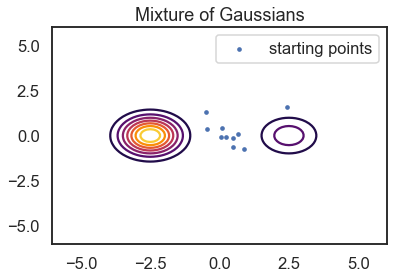

In [5]:
dim = 100
locs = torch.FloatTensor([[2.5]*(dim-1) + [0], [-2.5]*(dim-1) + [0]])
covs = 0.5 * torch.eye(dim)[None, ...].repeat(2, 1, 1).float()
weights = torch.FloatTensor([1, 3])

mog = MoG(locs.to(device), covs.to(device), weights.to(device))

ax = plt.subplot()
mog.plot_2d_countour(ax)


start_mog = torch.randn((N_CHAINS, mog.dim))
proj_slice = [PROJ_DIM1, PROJ_DIM2]
plt.scatter(*start_mog[:, proj_slice].T, s=10, label='starting points')
plt.title('Mixture of Gaussians')
plt.legend()
plt.show()

In [6]:
class Funnel(object):
    """
    Funnel distribution.

    “Slice sampling”. R. Neal, Annals of statistics, 705 (2003) https://doi.org/10.1214/aos/1056562461

    Args:
        dim - dimension
        nu - parameter
    """
    def __init__(self, dim: int, a: float=3):
        self._dim = dim
        self.a = a
        self.normal_last = Normal(0, a)

    @property
    def dim(self) -> int:
        return self._dim
    
    def log_prob(self, x: torch.FloatTensor) -> torch.FloatTensor:
        """
        Returns:
            log p(x)
        """

        normal_first = Normal(torch.zeros(x.shape[:-1], device=x.device), torch.exp(x[..., -1] / 2.))
        return normal_first.log_prob(x[..., :-1].permute(-1, *range(x.ndim-1))).sum(0) + \
            self.normal_last.log_prob(x[..., -1])

    def plot_2d_countour(self, ax):
        x = np.linspace(-15, 15, 100)
        y = np.linspace(-10, 10, 100)
        X, Y = np.meshgrid(x, y)
        inp = torch.from_numpy(np.stack([X, Y], -1))
        Z = self.log_prob(inp.reshape(-1, 2)).reshape(inp.shape[:-1])

        #levels = np.quantile(Z, np.linspace(0.9, 0.99, 5))
        ax.contour(X, Y, Z.exp(), 
                   #levels = levels,
                   levels=3, 
                   alpha=1., cmap='inferno')


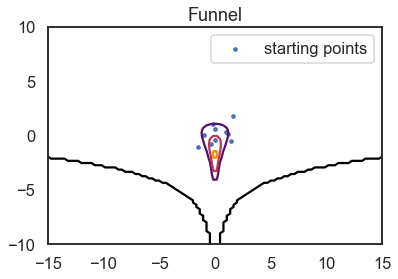

In [7]:
funnel = Funnel(100, 2)
ax = plt.subplot()
funnel.plot_2d_countour(ax)

start_funnel = torch.randn((N_CHAINS, funnel.dim))
proj_slice = [PROJ_DIM1, PROJ_DIM2]
plt.scatter(*start_funnel[:, proj_slice].T, s=10, label='starting points')
plt.title('Funnel')
plt.legend()
plt.show()

In [8]:
# some code for drawing

def ema(series: Iterable, n: int) -> List:
    """
    returns an n period exponential moving average for
    the time series
    """
    series = np.array(series)
    ema = []
    j = 1

    #get n sma first and calculate the next n period ema
    sma = sum(series[:n]) / n
    multiplier = 2 / float(1 + n)
    ema.append(sma)

    #EMA(current) = ( (Price(current) - EMA(prev) ) x Multiplier) + EMA(prev)
    ema.append(( (series[n] - sma) * multiplier) + sma)

    #now calculate the rest of the values
    for i in series[n+1:]:
        tmp = ( (i - ema[j]) * multiplier) + ema[j]
        j = j + 1
        ema.append(tmp)

    return ema

def plot_result(chains, dist, flow=None, chain_id=0, grid_n=100):
    proj_slice = [PROJ_DIM1, PROJ_DIM2]
    proj_dim1 = dist.dim + PROJ_DIM1 + 1 if PROJ_DIM1 < 0 else PROJ_DIM1 + 1
    proj_dim2 = dist.dim + PROJ_DIM2 + 1 if PROJ_DIM2 < 0 else PROJ_DIM2 + 1

    if flow:
        fig, axs = plt.subplots(1, 4, figsize=(17, 4))
    else: 
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    result = chains.reshape(-1, chains.shape[-1])
    dist.plot_2d_countour(axs[0])
    xmin, xmax = axs[0].get_xlim()
    ymin, ymax = axs[0].get_ylim()

    axs[0].scatter(*result[:, proj_slice].T, alpha=min(0.6, 1000./result.shape[0]), s=10)
    axs[0].set_title(f'Projected samples from {N_CHAINS} chains')

    kernel = gaussian_kde(result[:, proj_slice].T)
    x = np.linspace(xmin, xmax, grid_n)
    y = np.linspace(ymin, ymax, grid_n)
    X, Y = np.meshgrid(x, y)
    positions = np.vstack([X.ravel(), Y.ravel()])
    kde = np.reshape(kernel(positions).T, X.shape)
    axs[1].contour(X, Y, kde, cmap='inferno')
    axs[1].set_title(f'KDE')

    chain_id = 0
    result = chains[:, chain_id]
    dist.plot_2d_countour(axs[2])
    axs[2].plot(*result[:, proj_slice].T, alpha=min(0.6, 1000./result.shape[0]))
    axs[2].set_title(f'Trajectory of chain {chain_id}')

    if flow:
      flow_sample = flow.sample((10000,)).detach().cpu()
      kernel = gaussian_kde(flow_sample[:, proj_slice].T)
      kde = np.reshape(kernel(positions).T, X.shape)
      axs[3].contour(X, Y, kde, cmap='inferno')
      axs[3].set_title(f'KDE of NF samples')

    for ax in axs:
      ax.set_xlim(xmin, xmax)
      ax.set_ylim(ymin, ymax)
      ax.set_xlabel(fr'$X{proj_dim1}$')
      ax.set_ylabel(fr'$X{proj_dim2}$')

    fig.tight_layout()
    plt.show()
    

In [9]:
class RealNVPProposal(nn.Module):
    def __init__(self, dim: int, device: Union[str, int, torch.device], hidden: int = 32, num_blocks: int = 4):
        super(RealNVPProposal, self).__init__()
        
        self.prior = MNormal(
            torch.zeros(dim).to(device), 
            torch.eye(dim).to(device))
        
        masks = num_blocks * [[i % 2 for i in range(dim)], [(i + 1) % 2 for i in range(dim)]]
        masks = torch.FloatTensor(masks)
        self.masks = nn.Parameter(masks, requires_grad=False)

        self.t = torch.nn.ModuleList([nn.Sequential(
            nn.Linear(dim, hidden), nn.LeakyReLU(), 
            nn.Linear(hidden, hidden), nn.LeakyReLU(), 
            nn.Linear(hidden, dim)) 
                                      for _ in range(2 * num_blocks)])
        self.s = torch.nn.ModuleList([nn.Sequential(
            nn.Linear(dim, hidden), nn.LeakyReLU(), 
            nn.Linear(hidden, hidden), nn.LeakyReLU(), 
            nn.Linear(hidden, dim), nn.Tanh()) 
                                      for _ in range(2 * num_blocks)])
        
        self.to(device)

    def inv_flatten(self, z):
        log_det_J_inv, x = z.new_zeros(z.shape[0]), z
        for i in range(len(self.t)):
            x_ = x*self.masks[i]
            s = self.s[i](x_) * (1 - self.masks[i])
            t = self.t[i](x_) * (1 - self.masks[i])
            x = x_ + (1 - self.masks[i]) * (x * torch.exp(s) + t)

            log_det_J_inv += s.sum(dim=1)
        return x, log_det_J_inv

    def inv(self, z):
        dim = z.shape[-1]
        first_dims = z.shape[:-1]

        x, log_det_J_inv = self.inv_flatten(z.reshape(-1, dim))
        x = x.reshape(*z.shape)
        log_det_J_inv = log_det_J_inv.reshape(*first_dims)
        
        return x, log_det_J_inv
    
    def forward_flatten(self, x):
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in reversed(range(len(self.t))):
            z_ = self.masks[i] * z
            s = self.s[i](z_) * (1 - self.masks[i])
            t = self.t[i](z_) * (1 - self.masks[i])
            z = (1 - self.masks[i]) * (z - t) * torch.exp(-s) + z_
            log_det_J -= s.sum(dim=1)
        return z, log_det_J
    
    def forward(self, x):
        dim = x.shape[-1]
        first_dims = x.shape[:-1]

        z, log_det_J = self.forward_flatten(x.reshape(-1, dim))
        z = z.reshape(*x.shape)
        log_det_J = log_det_J.reshape(*first_dims)
        
        return z, log_det_J

    def log_prob(self, x):
        z, logp = self.forward(x)
        return self.prior.log_prob(z) + logp

    def sample(self, shape):
        z = self.prior.sample(shape).detach()
        x, log_det_J_inv = self.inv(z)
        #self.log_det_J_inv = log_det_J_inv
        return x


In [10]:
def isir_step(start: torch.FloatTensor, 
        target,
        proposal,
        *, 
        n_particles: int, 
        ) -> Tuple[torch.FloatTensor, torch.FloatTensor, torch.FloatTensor, float]:

    x = start.clone()
    logp_x = target.log_prob(x)
    logq_x = proposal.log_prob(x)

    particles = proposal.sample((x.shape[0], n_particles - 1))
    log_qs = torch.cat([logq_x[:, None], proposal.log_prob(particles)], 1)
    log_ps = torch.cat([logp_x[:, None], target.log_prob(particles)], 1)
    particles = torch.cat([x[:, None, :], particles], 1)

    log_weights = log_ps - log_qs
    indices = Categorical(logits=log_weights).sample()

    update = (indices != 0).float().mean().item()
    
    x = particles[np.arange(x.shape[0]), indices]
    logp_x = log_ps[np.arange(x.shape[0]), indices]
    logq_x = log_qs[np.arange(x.shape[0]), indices]

    return x, particles.detach(), log_ps, update


def MALA(start: torch.FloatTensor, 
        target, 
        n_samples: int,
        burn_in: int,
        *, 
        step_size: float, 
        verbose: bool=False) -> Tuple[torch.FloatTensor, List]:
    """
    Metropolis-Adjusted Langevin Algorithm with Normal proposal

    Args:
        start - strating points of shape [n_chains x dim]
        target - target distribution instance with method "log_prob"
        step_size - step size for drift term
        verbose - whether show iterations' bar

    Returns:
        sequence of slices per each iteration, acceptance rates per each iteration
    """
    std_normal = MNormal(torch.zeros(start.shape[-1], device=start.device), torch.eye(start.shape[-1], device=start.device))
    chains = []
    acceptance_rate = []
    
    x = start.clone()
    x.requires_grad_(True)
    x.grad = None
    logp_x = target.log_prob(x)
    grad_x = torch.autograd.grad(logp_x.sum(), x)[0]

    range_ = trange if verbose else range
    for step_id in range_(n_samples + burn_in):
        noise =  torch.randn_like(x)
        y = x + step_size * grad_x + noise * (2 * step_size) ** .5

        logp_y = target.log_prob(y)
        grad_y = torch.autograd.grad(logp_y.sum(), y)[0]

        log_qyx = std_normal.log_prob(noise)
        log_qxy = std_normal.log_prob((x - y - step_size * grad_y) / (2 * step_size) ** .5)
        
        accept_prob = torch.clamp((logp_y + log_qxy - logp_x - log_qyx).exp(), max=1)
        mask = torch.rand_like(accept_prob) < accept_prob

        with torch.no_grad():
            x[mask, :] = y[mask, :]
            logp_x[mask] = logp_y[mask]
            grad_x[mask] = grad_y[mask]

        acceptance_rate.append(mask.float().mean().item())
        if step_id >= burn_in:
            chains.append(x.detach().data.clone())
    chains = torch.stack(chains, 0)
    return chains, acceptance_rate


In [31]:
def NUTS(start,
        target, 
        n_samples: int,
        burn_in: int, 
        *, 
        step_size: float,
        verbose: bool = False) -> torch.FloatTensor:
    """
    No-U-Turn Sampler

    Args:
        start - strating points of shape [n_chains x dim]
        target - target distribution instance with method "log_prob"
        n_samples - number of last samples from each chain to return
        burn_in - number of first samples from each chain to throw away
        step_size - step size for drift term
        verbose - whether to show iterations' bar

    Returns:
        tensor of chains with shape [n_samples, n_chains, dim], acceptance rates for each iteration
    """

    x = start.clone()
    x.requires_grad_(False)
    def energy(z):
        z = z["points"]
        return -target.log_prob(z).sum()

    kernel = pyro_nuts(
        potential_fn=energy, step_size=step_size, full_mass=False
        )

    init_params = {"points": x}
    mcmc_true = MCMC(
        kernel=kernel,
        num_samples=n_samples,
        initial_params=init_params,
        warmup_steps=burn_in,
    )
    mcmc_true.run()

    q_true = mcmc_true.get_samples(group_by_chain=True)["points"]
    samples_true = q_true.view(-1, *start.shape)

    return samples_true


def HMC(start,
        target, 
        n_samples: int,
        burn_in: int, 
        *, 
        step_size: float,
        num_leapfrog_steps: float = 1,
        verbose: bool = False) -> torch.FloatTensor:
    """
    Hamiltonian Monte Carlo

    Args:
        start - strating points of shape [n_chains x dim]
        target - target distribution instance with method "log_prob"
        n_samples - number of last samples from each chain to return
        burn_in - number of first samples from each chain to throw away
        step_size - step size for drift term
        verbose - whether to show iterations' bar

    Returns:
        tensor of chains with shape [n_samples, n_chains, dim], acceptance rates for each iteration
    """

    x = start.clone()
    x.requires_grad_(False)
    def energy(z):
        z = z["points"]
        return -target.log_prob(z).sum()

    kernel = pyro_hmc(
        potential_fn=energy, step_size=step_size, num_steps=num_leapfrog_steps, full_mass=False
        )

    init_params = {"points": x}
    mcmc_true = MCMC(
        kernel=kernel,
        num_samples=n_samples,
        initial_params=init_params,
        warmup_steps=burn_in,
    )
    mcmc_true.run()

    q_true = mcmc_true.get_samples(group_by_chain=True)["points"]
    samples_true = q_true.view(-1, *start.shape)

    return samples_true

In [44]:
def FlEx2MCMC(
    start: torch.FloatTensor, 
    target, 
    proposal, 
    n_samples: int, 
    burn_in: int, 
    *,
    n_particles: int,
    step_size: float,
    n_mala_steps: int, 
    add_pop_size_train: int= 4096,
    forward_kl_weight=1.,
    backward_kl_weight=1.,
    verbose: bool = False
    ) -> Tuple[torch.FloatTensor, Dict]:
    """
    Ex2MCMC with Flow proposal

    Args:
        start - strating points of shape [n_chains x dim]
        target - target distribution instance with method "log_prob"
        proposal - instance of RealNVPProposa
        n_samples - number of last samples from each chain to return
        burn_in - number of first samples from each chain to throw away
        step_size - step size for drift term
        n_particles - number of particles including one from previous step
        n_mala_steps - number of MALA steps after each SIR step
        verbose - whether to show iterations' bar

    Returns:
        tensor of chains with shape [n_samples, n_chains, dim], acceptance rates for each iteration
    """
    chains = []
    progress = dict(
        acceptance_rates=[],
        forward_kl=[],
        backward_kl=[],
        )
    x = start.clone()
    x.requires_grad_(True)
    x.grad = None

    proposal_opt = torch.optim.Adam(proposal.parameters(), lr=1e-3)
    hist_proposals = None
    
    pbar = trange(n_samples + burn_in) if verbose else range(n_samples + burn_in)
    for step_id in pbar:
        x = x.data
        x.requires_grad_(True)

        x, proposals, log_ps, accepted = isir_step(x, target, proposal, n_particles=n_particles)
        progress['acceptance_rates'].append(accepted)
        x = MALA(x, target, n_mala_steps, n_mala_steps-1, step_size=step_size, verbose=False)[0][-1]
        
        if step_id >= burn_in:
            chains.append(x.detach().data.clone().cpu())
        else:
          # forward KL
          proposals_flattened = proposals.reshape(-1, x.shape[-1])
          log_ps_flattened = log_ps.reshape(-1).detach()
          
          if hist_proposals is not None:
              idxs = np.random.choice(hist_proposals.shape[0], add_pop_size_train)
              proposals_flattened = torch.cat((proposals_flattened, hist_proposals[idxs]), dim=0)
              log_ps_flattened = torch.cat((log_ps_flattened, hist_log_ps[idxs]), dim=0)

          log_qs = proposal.log_prob(proposals_flattened)
          logw = log_ps_flattened - log_qs.detach()
          
          kl_forw = -(log_qs * torch.softmax(logw, dim=0)).sum()
          
          # backward KL
          _, log_det_J = proposal.forward(proposals[:, 1:])
          kl_back = -(log_ps[:, 1:] + log_det_J).mean()
          
          # entropy reg
          e = -proposal.log_prob(proposal.prior.sample(proposals.shape)).mean()
          
          loss = forward_kl_weight * kl_forw + backward_kl_weight * kl_back + 0.1 * e
          proposal_opt.zero_grad()
          loss.backward()
          proposal_opt.step()

          progress['forward_kl'].append(kl_forw.item())
          progress['backward_kl'].append(kl_back.item())
          
          if verbose:
              pbar.set_description(f"KL forw {kl_forw.item():.3f}, KL back {kl_back.item():.3f} Hentr {e.item():.3f}")

          if hist_proposals is None:
              hist_proposals = proposals_flattened
              hist_log_ps = log_ps_flattened
          else:
              hist_proposals = torch.cat((hist_proposals, proposals_flattened), dim=0)
              hist_log_ps = torch.cat((hist_log_ps, log_ps_flattened), dim=0)
        
    chains = torch.stack(chains, 0)
    
    return chains, progress

In [13]:
step_size = 0.1

chains, _ = MALA(start_mog.to(device), mog, N_SAMPLES, BURN_IN, step_size=step_size, verbose=True)

100%|██████████| 1000/1000 [00:02<00:00, 446.41it/s]


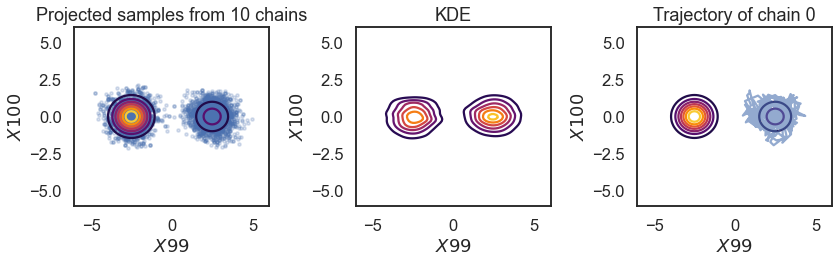

In [14]:
plot_result(chains.cpu(), mog)

In [15]:
step_size = 0.1

chains = NUTS(start_mog.to(device), mog, N_SAMPLES, BURN_IN, step_size=step_size, verbose=True)

Sample: 100%|██████████| 1000/1000 [00:31, 32.00it/s, step size=2.57e-01, acc. prob=0.866]


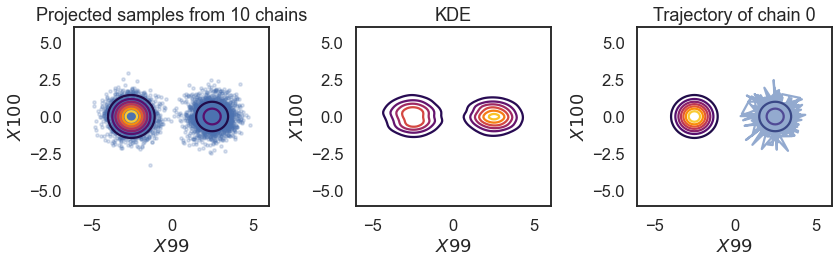

In [16]:
plot_result(chains.cpu(), mog)

In [17]:
step_size = 0.1
n_particles = 10
n_mala_steps = 1

proposal = RealNVPProposal(mog.dim, device=device, num_blocks=4)

chains, progress = FlEx2MCMC(
    start_mog.to(device), 
    mog, proposal, 
    N_SAMPLES, 
    BURN_IN, 
    step_size=step_size, 
    n_particles=n_particles, 
    n_mala_steps=n_mala_steps, 
    forward_kl_weight=1.0,
    backward_kl_weight=0.1,
    verbose=True)

KL forw 123.41651916503906, KL back 115.39234924316406 Hentr 166.0719451904297: 100%|██████████| 1000/1000 [00:42<00:00, 23.67it/s]


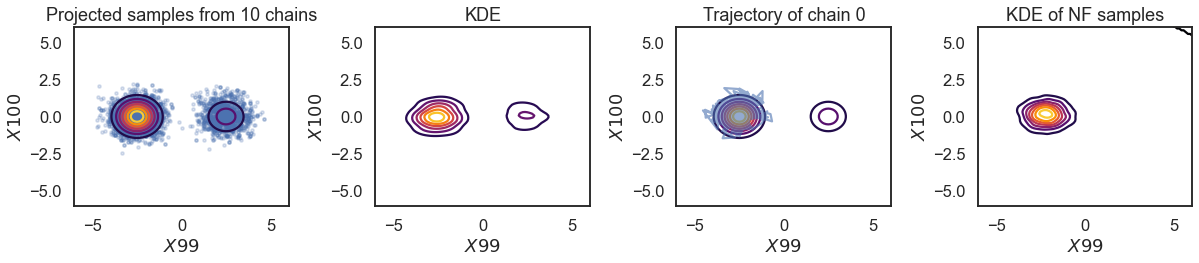

In [18]:
plot_result(chains, mog, proposal)

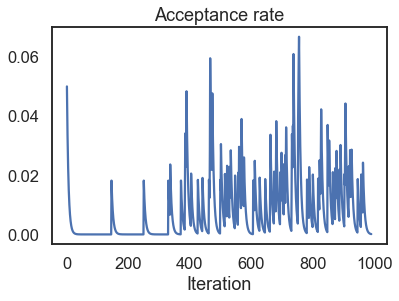

In [19]:
plt.plot(ema(progress['acceptance_rates'], 10))
plt.title('Acceptance rate')
plt.xlabel('Iteration')
plt.show()

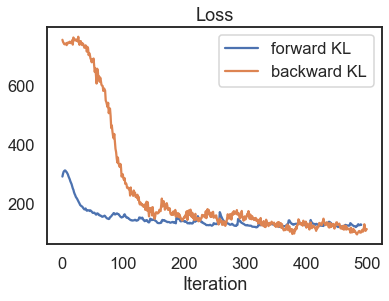

In [20]:
plt.plot(ema(progress['forward_kl'], 10), label='forward KL')
plt.plot(progress['backward_kl'], label='backward KL')
plt.title('Loss')
plt.xlabel('Iteration')
plt.legend()
plt.show()

In [23]:
step_size = 0.1
n_particles = 50
n_mala_steps = 3

proposal = RealNVPProposal(funnel.dim, device=device, num_blocks=4)

chains, progress = FlEx2MCMC(
    start_funnel.to(device), 
    funnel, 
    proposal, 
    N_SAMPLES, 
    BURN_IN, 
    step_size=step_size, 
    n_particles=n_particles, 
    n_mala_steps=n_mala_steps, 
    forward_kl_weight=0.1,
    backward_kl_weight=1.0,
    verbose=True)

KL forw 7955.786, KL back 401.330 Hentr 330.850: 100%|██████████| 1000/1000 [01:24<00:00, 11.88it/s]    


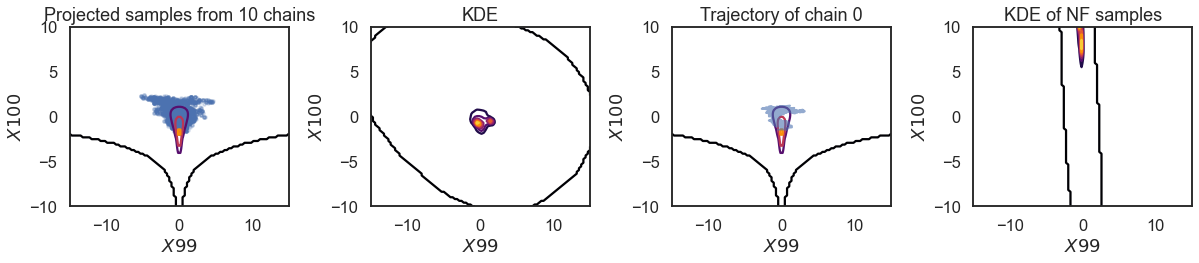

In [24]:
plot_result(chains, funnel, proposal)

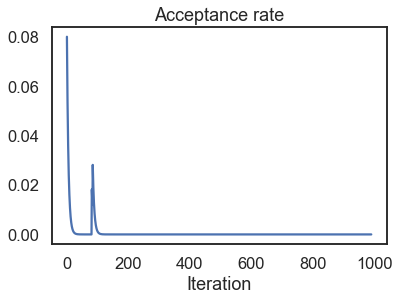

In [25]:
plt.plot(ema(progress['acceptance_rates'], 10))
plt.title('Acceptance rate')
plt.xlabel('Iteration')
plt.show()

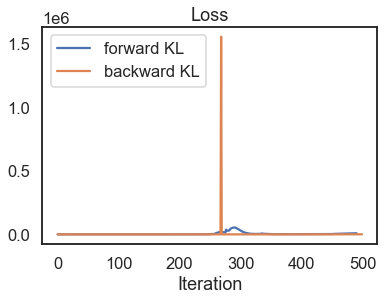

In [26]:
plt.plot(ema(progress['forward_kl'], 10), label='forward KL')
plt.plot(progress['backward_kl'], label='backward KL')
plt.title('Loss')
plt.xlabel('Iteration')
plt.legend()
plt.show()

In [45]:
step_size = 0.1
n_particles = 50
n_mala_steps = 3

proposal = RealNVPProposal(funnel.dim, device=device, num_blocks=4)

chains, progress = FlEx2MCMC(
    start_funnel.to(device), 
    funnel, 
    proposal, 
    N_SAMPLES,
    BURN_IN, 
    step_size=step_size, 
    n_particles=n_particles, 
    n_mala_steps=n_mala_steps, 
    forward_kl_weight=1.5,
    backward_kl_weight=0.1,
    verbose=True)

KL forw 142.850, KL back 105.169 Hentr 151.721: 100%|██████████| 1000/1000 [01:10<00:00, 14.21it/s]


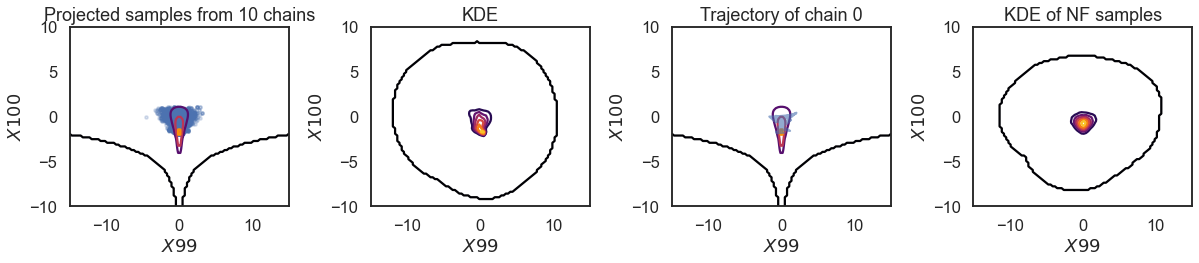

In [46]:
plot_result(chains, funnel, proposal)

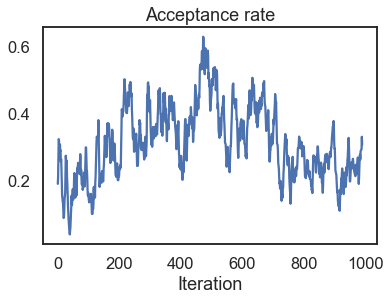

In [47]:
plt.plot(ema(progress['acceptance_rates'], 10))
plt.title('Acceptance rate')
plt.xlabel('Iteration')
plt.show()

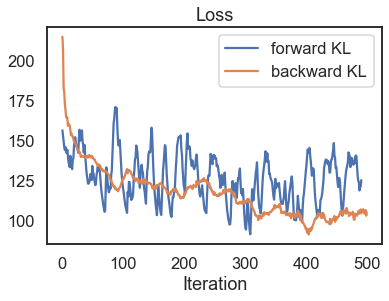

In [48]:
plt.plot(ema(progress['forward_kl'], 10), label='forward KL')
plt.plot(progress['backward_kl'], label='backward KL')
plt.title('Loss')
plt.xlabel('Iteration')
plt.legend()
plt.show()

In [36]:
step_size = 0.1
num_leapfrog_steps = 10

chains = HMC(start_funnel.to(device), funnel, N_SAMPLES, BURN_IN, step_size=step_size, num_leapfrog_steps=num_leapfrog_steps, verbose=True)

Sample: 100%|██████████| 1000/1000 [00:08, 122.43it/s, step size=1.11e-01, acc. prob=0.740]


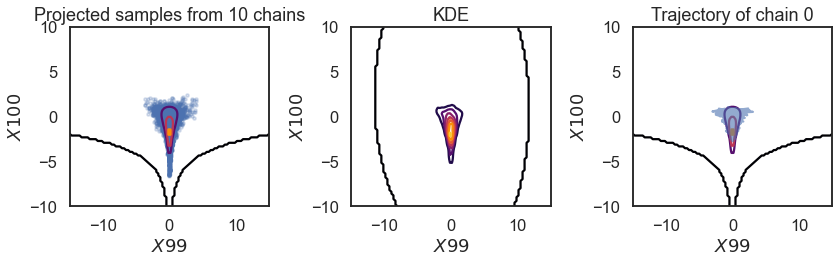

In [37]:
plot_result(chains.cpu(), funnel)

In [ ]:
# step_size = 0.1

# chains = NUTS(start_funnel.to(device), funnel, N_SAMPLES, BURN_IN, step_size=step_size, verbose=True)

In [ ]:
# plot_result(chains.cpu(), funnel)